# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.09561538696289062ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [4]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='happy')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

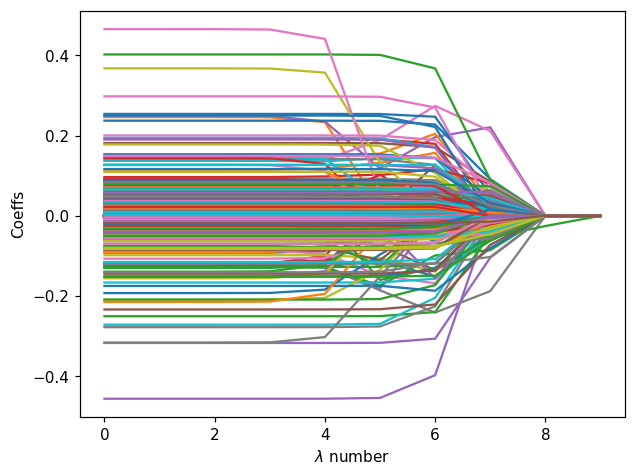

In [5]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [6]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [7]:
np.save('data/Lasso_Ranking_happy_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_happy_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.6368
Iter =  2  AUC = 0.6659
Iter =  6  AUC = 0.6889
Iter =  7  AUC = 0.6963
Iter =  13  AUC = 0.6979
Iter =  17  AUC = 0.7063
Iter =  18  AUC = 0.7179
Iter =  19  AUC = 0.7224
Iter =  34  AUC = 0.7260
Iter =  46  AUC = 0.7262
Iter =  47  AUC = 0.7280
Iter =  51  AUC = 0.7288
Iter =  53  AUC = 0.7388
Iter =  54  AUC = 0.7414
Iter =  56  AUC = 0.7604
Iter =  60  AUC = 0.7772
Iter =  63  AUC = 0.7792
Iter =  68  AUC = 0.7849
Iter =  73  AUC = 0.7929
auc_best = 0.79286859


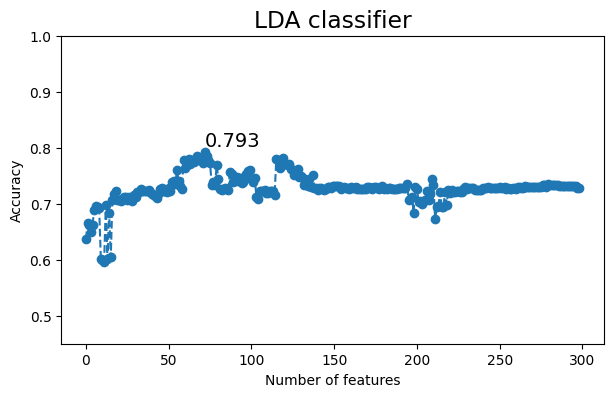

In [8]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [9]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.7928685897435898 Number of features =  72


# Backward step selection

In [10]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [11]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.795 <-> 0.793
Iter #1: 0.763 <-> 0.793
Iter #2: 0.771 <-> 0.793
Iter #3: 0.755 <-> 0.793
Iter #4: 0.783 <-> 0.793
Iter #5: 0.774 <-> 0.793
Iter #6: 0.774 <-> 0.793
Iter #7: 0.772 <-> 0.793
Iter #8: 0.771 <-> 0.793
Iter #9: 0.770 <-> 0.793
Iter #10: 0.778 <-> 0.793
Iter #11: 0.785 <-> 0.793
Iter #12: 0.783 <-> 0.793
Iter #13: 0.774 <-> 0.793
Iter #14: 0.790 <-> 0.793
Iter #15: 0.784 <-> 0.793
Iter #16: 0.773 <-> 0.793
Iter #17: 0.803 <-> 0.793
Iter #18: 0.771 <-> 0.793
Iter #19: 0.793 <-> 0.793
Iter #20: 0.762 <-> 0.793
Iter #21: 0.772 <-> 0.793
Iter #22: 0.776 <-> 0.793
Iter #23: 0.760 <-> 0.793
Iter #24: 0.767 <-> 0.793
Iter #25: 0.788 <-> 0.793
Iter #26: 0.790 <-> 0.793
Iter #27: 0.800 <-> 0.793
Iter #28: 0.799 <-> 0.793
Iter #29: 0.792 <-> 0.793
Iter #30: 0.790 <-> 0.793
Iter #31: 0.745 <-> 0.793
Iter #32: 0.773 <-> 0.793
Iter #33: 0.784 <-> 0.793
Iter #34: 0.793 <-> 0.793
Iter #35: 0.793 <-> 0.793
Iter #36: 0.793 <-> 0.793
Iter #37: 0.793 <-> 0.793
Iter #38: 0.

Iter #24: 0.810 <-> 0.812
Iter #25: 0.803 <-> 0.812
Iter #26: 0.754 <-> 0.812
Iter #27: 0.800 <-> 0.812
Iter #28: 0.813 <-> 0.812
Iter #29: 0.804 <-> 0.812
Iter #30: 0.804 <-> 0.812
Iter #31: 0.804 <-> 0.812
Iter #32: 0.804 <-> 0.812
Iter #33: 0.804 <-> 0.812
Iter #34: 0.774 <-> 0.812
Iter #35: 0.772 <-> 0.812
Iter #36: 0.803 <-> 0.812
Iter #37: 0.769 <-> 0.812
Iter #38: 0.778 <-> 0.812
Iter #39: 0.783 <-> 0.812
Iter #40: 0.800 <-> 0.812
Iter #41: 0.756 <-> 0.812
Iter #42: 0.782 <-> 0.812
Iter #43: 0.756 <-> 0.812
Iter #44: 0.794 <-> 0.812
Iter #45: 0.795 <-> 0.812
Iter #46: 0.786 <-> 0.812
Iter #47: 0.769 <-> 0.812
Iter #48: 0.718 <-> 0.812
Iter #49: 0.802 <-> 0.812
Iter #50: 0.806 <-> 0.812
Iter #51: 0.728 <-> 0.812
Iter #52: 0.805 <-> 0.812
Iter #53: 0.768 <-> 0.812
Iter #54: 0.806 <-> 0.812
Iter #55: 0.786 <-> 0.812
Iter #56: 0.798 <-> 0.812
Iter #57: 0.814 <-> 0.812
Iter #58: 0.810 <-> 0.812
Iter #59: 0.793 <-> 0.812
Iter #60: 0.798 <-> 0.812
Iter #61: 0.796 <-> 0.812
Iter #62: 0.

Iter #64: 0.790 <-> 0.812
Withdraw feature #28, added accracy 0
NEW ROUND
Iter #0: 0.780 <-> 0.812
Iter #1: 0.780 <-> 0.812
Iter #2: 0.756 <-> 0.812
Iter #3: 0.741 <-> 0.812
Iter #4: 0.787 <-> 0.812
Iter #5: 0.769 <-> 0.812
Iter #6: 0.747 <-> 0.812
Iter #7: 0.804 <-> 0.812
Iter #8: 0.803 <-> 0.812
Iter #9: 0.783 <-> 0.812
Iter #10: 0.728 <-> 0.812
Iter #11: 0.783 <-> 0.812
Iter #12: 0.794 <-> 0.812
Iter #13: 0.763 <-> 0.812
Iter #14: 0.811 <-> 0.812
Iter #15: 0.795 <-> 0.812
Iter #16: 0.775 <-> 0.812
Iter #17: 0.777 <-> 0.812
Iter #18: 0.779 <-> 0.812
Iter #19: 0.774 <-> 0.812
Iter #20: 0.767 <-> 0.812
Iter #21: 0.776 <-> 0.812
Iter #22: 0.770 <-> 0.812
Iter #23: 0.773 <-> 0.812
Iter #24: 0.795 <-> 0.812
Iter #25: 0.778 <-> 0.812
Iter #26: 0.768 <-> 0.812
Iter #27: 0.808 <-> 0.812
Iter #28: 0.813 <-> 0.812
Iter #29: 0.813 <-> 0.812
Iter #30: 0.788 <-> 0.812
Iter #31: 0.795 <-> 0.812
Iter #32: 0.811 <-> 0.812
Iter #33: 0.808 <-> 0.812
Iter #34: 0.761 <-> 0.812
Iter #35: 0.788 <-> 0.812


Iter #57: 0.804 <-> 0.819
Iter #58: 0.821 <-> 0.819
Iter #59: 0.776 <-> 0.819
Withdraw feature #4, added accracy 0
NEW ROUND
Iter #0: 0.795 <-> 0.823
Iter #1: 0.783 <-> 0.823
Iter #2: 0.753 <-> 0.823
Iter #3: 0.708 <-> 0.823
Iter #4: 0.770 <-> 0.823
Iter #5: 0.819 <-> 0.823
Iter #6: 0.794 <-> 0.823
Iter #7: 0.782 <-> 0.823
Iter #8: 0.757 <-> 0.823
Iter #9: 0.816 <-> 0.823
Iter #10: 0.767 <-> 0.823
Iter #11: 0.788 <-> 0.823
Iter #12: 0.811 <-> 0.823
Iter #13: 0.801 <-> 0.823
Iter #14: 0.821 <-> 0.823
Iter #15: 0.807 <-> 0.823
Iter #16: 0.802 <-> 0.823
Iter #17: 0.806 <-> 0.823
Iter #18: 0.827 <-> 0.823
Iter #19: 0.766 <-> 0.823
Iter #20: 0.814 <-> 0.823
Iter #21: 0.775 <-> 0.823
Iter #22: 0.776 <-> 0.823
Iter #23: 0.786 <-> 0.823
Iter #24: 0.811 <-> 0.823
Iter #25: 0.762 <-> 0.823
Iter #26: 0.789 <-> 0.823
Iter #27: 0.800 <-> 0.823
Iter #28: 0.803 <-> 0.823
Iter #29: 0.793 <-> 0.823
Iter #30: 0.799 <-> 0.823
Iter #31: 0.752 <-> 0.823
Iter #32: 0.822 <-> 0.823
Iter #33: 0.764 <-> 0.823
I

In [13]:
np.save('data/feature_idx_happy.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_happy.npy')

# 5-fold CV (full feature space)

In [14]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.71it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.60it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.16it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.47it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.73it/s]

UAR = 0.456


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.83it/s]

UAR = 0.454


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.38it/s]

UAR = 0.444


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.37it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.43it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


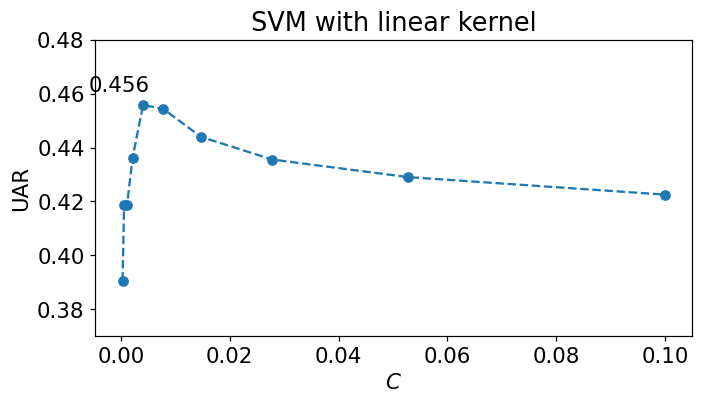

In [15]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

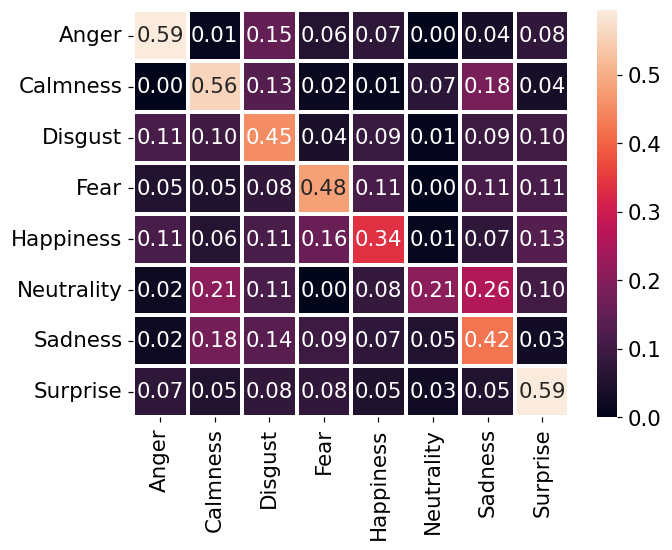

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [16]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [17]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [18]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-1.276835,-0.517756,-0.059227,-1.326179,-0.358021,-0.125111,0.172226,1.972389,-0.340691,0.783819,...,0.192121,0.259674,0.090353,0.508042,-0.265415,-0.023326,-0.554962,-1.237381,-0.498843,0.475320
1,-1.043824,0.220502,-0.243866,-0.746059,-1.261154,1.343100,0.613144,0.647493,-0.762145,0.297960,...,-1.076843,0.214233,0.091523,-0.112864,-0.083767,0.433128,-0.601412,0.172521,-1.835939,-0.832132
2,-0.935299,0.313672,0.708621,0.392777,-1.260522,-0.256055,0.981156,0.152506,-0.826127,-0.634355,...,-0.794728,-0.727784,-0.578290,-3.309826,0.997258,-0.024385,-0.019360,0.709017,0.474211,0.645414
3,-1.784177,-0.222563,-0.352883,-1.355222,0.112386,-0.107841,-0.562788,1.409404,-0.165081,0.094568,...,0.804045,2.049866,1.857826,0.094915,-0.788535,-0.510788,-0.316807,-0.062229,-0.241982,0.049539
4,-1.564315,-0.373531,-0.273308,-1.374829,0.913175,0.020091,0.343931,1.757624,0.046708,0.070402,...,1.421066,1.604395,1.846153,0.194419,0.221644,-0.110215,-0.584912,-1.189150,0.075245,-0.418597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-0.318359,-1.093245,-0.582902,-1.118079,0.520587,0.642538,0.995423,-0.402387,0.585410,0.699843,...,0.508418,0.642702,0.777180,0.502291,-1.874090,-0.765149,-0.616793,-0.921252,-0.078363,-0.120336
1436,-0.526947,-1.554782,-1.162640,-0.190430,0.380144,0.246054,-0.063867,0.399012,0.095599,1.464856,...,1.957225,0.593928,1.371392,1.424132,-0.629525,-1.368302,-0.335131,-1.655463,-0.533185,-0.744387
1437,-0.515158,-1.455403,-1.037404,-1.930804,-0.164582,0.032885,0.205071,-0.567749,0.129536,1.172297,...,-0.068406,-0.706256,-0.538518,0.917660,-1.189714,0.509777,-0.832675,-1.666370,0.138570,-0.277073
1438,0.238985,-0.858478,-0.689952,-1.191132,-0.785490,-0.989785,1.012529,0.113842,-0.580327,0.567737,...,-0.218067,0.027501,-0.545950,0.107728,1.492651,0.482770,0.516159,-0.202054,0.164651,-0.226308


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.21it/s]

UAR = 0.318


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.73it/s]

UAR = 0.328


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.44it/s]

UAR = 0.335


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.95it/s]

UAR = 0.354


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.55it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.01it/s]

UAR = 0.374


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.04it/s]

UAR = 0.383


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.27it/s]

UAR = 0.390


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.87it/s]

UAR = 0.391


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.65it/s]

UAR = 0.392


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.37it/s]

UAR = 0.397


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.85it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.09it/s]

UAR = 0.398


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.56it/s]

UAR = 0.390


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.40it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.04it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.77it/s]

UAR = 0.409


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.64it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.89it/s]

UAR = 0.432


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.70it/s]

UAR = 0.430


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.43it/s]

UAR = 0.430


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.93it/s]

UAR = 0.430


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.04it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.62it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.38it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.14it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.94it/s]

UAR = 0.422


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.50it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.76it/s]

UAR = 0.416


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.20it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.91it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.22it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.63it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.12it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.09it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.80it/s]

UAR = 0.410


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.88it/s]

UAR = 0.404


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.12it/s]

UAR = 0.403


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.12it/s]

UAR = 0.402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


UAR = 0.404
UAR_best = 0.432, C_best = 0.013


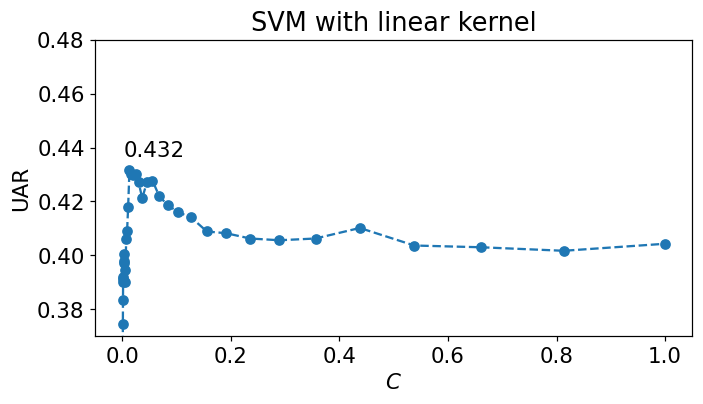

In [19]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

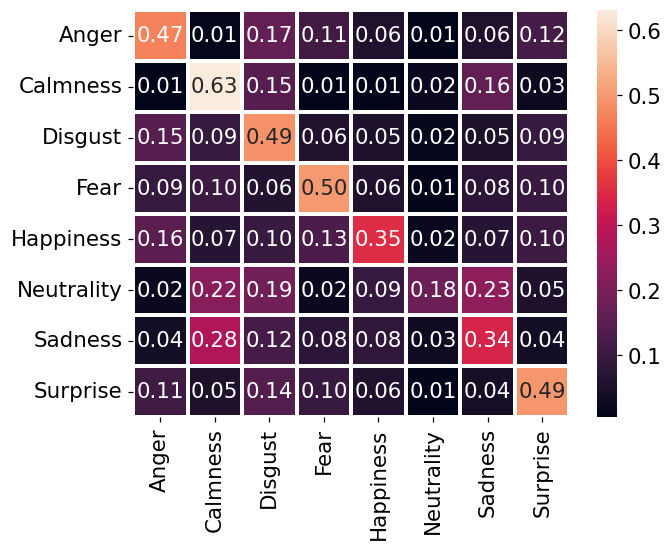

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)